# Physics-informed Neural Networks (PINNs) - Burgers Equation

This notebook implements the Physics-informed Neural Network (PINN) for solving the Burgers equation using PyTorch, with 3D visualization using Plotly.

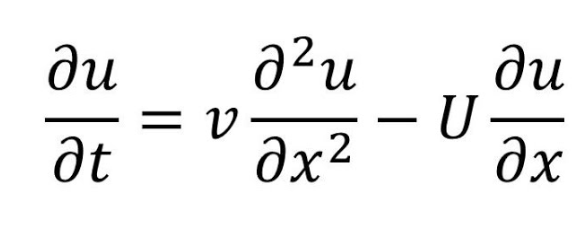

In [1]:
# Import required libraries
import torch
from collections import OrderedDict
import numpy as np
import plotly.graph_objects as go
import scipy.io
from scipy.interpolate import griddata
import warnings

warnings.filterwarnings('ignore')
np.random.seed(1234)

In [2]:
def burgers_solution_test():

    #*****************************************************************************80
    #
    ## burgers_solution_test tests burgers_solution.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    27 September 2015
    #
    #  Author:
    #
    #    John Burkardt
    #
    import platform

    print('')
    print('burgers_solution_test():')
    print('  Python version: %s' % (platform.python_version()))
    print(
        '  burgers_solution evaluates exact solutions of the Burgers equation.')

    burgers_viscous_time_exact1_test01()

    #
    #  Terminate.
    #
    print('')
    print('burgers_solution_test():')
    print('  Normal end of execution.')
    return


def burgers_viscous_time_exact1(nu, vxn, vx, vtn, vt):

    #*****************************************************************************80
    #
    ## burgers_viscous_time_exact1() evaluates a solution to the Burgers equation.
    #
    #  Discussion:
    #
    #    The form of the Burgers equation considered here is
    #
    #      du       du        d^2 u
    #      -- + u * -- = nu * -----
    #      dt       dx        dx^2
    #
    #    for -1.0 < x < +1.0, and 0 < t.
    #
    #    Initial conditions are u(x,0) = - sin(pi*x).  Boundary conditions
    #    are u(-1,t) = u(+1,t) = 0.  The viscosity parameter nu is taken
    #    to be 0.01 / pi, although this is not essential.
    #
    #    The authors note an integral representation for the solution u(x,t),
    #    and present a better version of the formula that is amenable to
    #    approximation using Hermite quadrature.
    #
    #    This program library does little more than evaluate the exact solution
    #    at a user-specified set of points, using the quadrature rule.
    #    Internally, the order of this quadrature rule is set to 8, but the
    #    user can easily modify this value if greater accuracy is desired.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    24 September 2015
    #
    #  Author:
    #
    #    John Burkardt.
    #
    #  Reference:
    #
    #    Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
    #    J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
    #    Spectral and finite difference solutions of the Burgers equation,
    #    Computers and Fluids,
    #    Volume 14, Number 1, 1986, pages 23-41.
    #
    #  Input:
    #
    #    real NU, the viscosity.
    #
    #    integer VXN, the number of spatial grid points.
    #
    #    real VX(VXN), the spatial grid points.
    #
    #    integer VTN, the number of time grid points.
    #
    #    real VT(VTN), the time grid points.
    #
    #  Output:
    #
    #    real VU(VXN,VTN), the solution of the Burgers
    #    equation at each space and time grid point.
    #
    import numpy as np
    
    #---------------------------------------
    # qn = 8   # original value
    qn = 50
    print('  Quadrature order = %d' % (qn))
    #---------------------------------------
    
    #
    #  Compute the rule.
    #
    qx, qw = hermite_ek_compute(qn)
    #
    #  Evaluate U(X,T) for later times.
    #
    vu = np.zeros([vxn, vtn])

    for vti in range(0, vtn):

        if (vt[vti] == 0.0):

            for i in range(0, vxn):
                vu[i, vti] = -np.sin(np.pi * vx[i])

        else:

            for vxi in range(0, vxn):

                top = 0.0
                bot = 0.0

                for qi in range(0, qn):

                    c = 2.0 * np.sqrt(nu * vt[vti])

                    top = top - qw[qi] * c * np.sin ( np.pi * ( vx[vxi] - c * qx[qi] ) ) \
                      * np.exp ( - np.cos ( np.pi * ( vx[vxi] - c * qx[qi]  ) ) \
                      / ( 2.0 * np.pi * nu ) )

                    bot = bot + qw[qi] * c \
                      * np.exp ( - np.cos ( np.pi * ( vx[vxi] - c * qx[qi]  ) ) \
                      / ( 2.0 * np.pi * nu ) )

                    vu[vxi, vti] = top / bot

    return vu


def burgers_viscous_time_exact1_test01():

    #*****************************************************************************80
    #
    ## burgers_viscous_time_exact1_test01() tests sets up a small test case.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    24 September 2015
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    vtn = 100
    vxn = 256
    nu = 0.01 / np.pi

    #print('')
    print('burgers_viscous_time_exact1_test01():')
    print('  Python version: %s' % (platform.python_version()))
    print('  burgers_viscous_time_exact1() evaluates solution #1')
    print('  to the Burgers equation.')
    print('')
    print('  Viscosity NU = %g' % (nu))
    print('  NX = %d' % (vxn))
    print('  NT = %d' % (vtn))

    xlo = -1.0
    xhi = +1.0
    vx = np.linspace(xlo, xhi, vxn)
    #r8vec_print(vxn, vx, '  X grid points:')
    np.savetxt("burgers_solution_x.csv", vx, delimiter=",")

    tlo = 0.0
    # thi = 3.0 / np.pi
    thi = 0.99
    vt = np.linspace(tlo, thi, vtn)
    #r8vec_print(vtn, vt, '  T grid points:')
    np.savetxt("burgers_solution_t.csv", vt, delimiter=",")

    vu = burgers_viscous_time_exact1(nu, vxn, vx, vtn, vt)
    np.savetxt("burgers_solution_u.csv", vu, delimiter=",")
    
    #r8mat_print(vxn, vtn, vu, '  U(X,T) at grid points:')
    #filename = 'burgers_solution_test01.txt'
    #r8mat_write(filename, vxn, vtn, vu)
    #print('')
    #print('  Data written to file "%s"' % (filename))
    #
    #  Terminate
    #
    #print('')
    #print('burgers_viscous_time_exact1_test01():')
    #print('  Normal end of execution.')
    return


def burgers_viscous_time_exact2(nu, xn, x, tn, t):

    #*****************************************************************************80
    #
    ## burgers_viscous_time_exact2() evaluates a solution to the Burgers equation.
    #
    #  Discussion:
    #
    #    The form of the Burgers equation considered here is
    #
    #      du       du        d^2 u
    #      -- + u * -- = nu * -----
    #      dt       dx        dx^2
    #
    #    for 0.0 < x < 2 Pi, and 0 < t.
    #
    #    The initial condition is
    #
    #      u(x,0) = 4 - 2 * nu * dphi(x,0)/dx / phi(x,0)
    #
    #    where
    #
    #      phi(x,t) = exp ( - ( x-4*t      ) / ( 4*nu*(t+1) ) )
    #               + exp ( - ( x-4*t-2*pi ) / ( 4*nu*(t+1) ) )
    #
    #    The boundary conditions are periodic:
    #
    #      u(0,t) = u(2 Pi,t)
    #
    #    The viscosity parameter nu may be taken to be 0.01, but other values
    #    may be chosen.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    27 September 2015
    #
    #  Author:
    #
    #    John Burkardt.
    #
    #  Reference:
    #
    #    Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
    #    J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
    #    Spectral and finite difference solutions of the Burgers equation,
    #    Computers and Fluids,
    #    Volume 14, Number 1, 1986, pages 23-41.
    #
    #  Input:
    #
    #    real NU, the viscosity.
    #
    #    integer XN, the number of spatial grid points.
    #
    #    real X(XN), the spatial grid points.
    #
    #    integer TN, the number of time grid points.
    #
    #    real T(TN), the time grid points.
    #
    #  Output:
    #
    #    real U(XN,TN), the solution of the Burgers
    #    equation at each space and time grid point.
    #
    import numpy as np

    u = np.zeros([xn, tn])

    for j in range(0, tn):

        for i in range(0, xn):

            a = (x[i] - 4.0 * t[j])
            b = (x[i] - 4.0 * t[j] - 2.0 * np.pi)
            c = 4.0 * nu * (t[j] + 1.0)
            phi = np.exp(-a * a / c) + np.exp(-b * b / c)
            dphi = - 2.0 * a * np.exp ( - a * a / c ) / c \
                   - 2.0 * b * np.exp ( - b * b / c ) / c
            u[i, j] = 4.0 - 2.0 * nu * dphi / phi

    return u


def hermite_ek_compute(n):

    #*****************************************************************************80
    #
    ## hermite_ek_compute() computes a Gauss-Hermite quadrature rule.
    #
    #  Discussion:
    #
    #    The code uses an algorithm by Elhay and Kautsky.
    #
    #    The abscissas are the zeros of the N-th order Hermite polynomial.
    #
    #    The integral:
    #
    #      integral ( -oo < x < +oo ) exp ( - x * x ) * f(x) dx
    #
    #    The quadrature rule:
    #
    #      sum ( 1 <= i <= n ) w(i) * f ( x(i) )
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    15 June 2015
    #
    #  Author:
    #
    #    John Burkardt.
    #
    #  Reference:
    #
    #    Sylvan Elhay, Jaroslav Kautsky,
    #    Algorithm 655: IQPACK, FORTRAN Subroutines for the Weights of
    #    Interpolatory Quadrature,
    #    ACM Transactions on Mathematical Software,
    #    Volume 13, Number 4, December 1987, pages 399-415.
    #
    #  Input:
    #
    #    integer N, the number of abscissas.
    #
    #  Output:
    #
    #    real X(N), the abscissas.
    #
    #    real W(N), the weights.
    #
    from scipy.special import gamma
    import numpy as np
    #
    #  Define the zero-th moment.
    #
    zemu = gamma(0.5)
    #
    #  Define the Jacobi matrix.
    #
    bj = np.zeros(n)
    for i in range(0, n):
        bj[i] = np.sqrt(float(i + 1) / 2.0)

    x = np.zeros(n)

    w = np.zeros(n)
    w[0] = np.sqrt(zemu)
    #
    #  Diagonalize the Jacobi matrix.
    #
    x, w = imtqlx(n, x, bj, w)
    #
    #  If N is odd, force the center X to be exactly 0.
    #
    if ((n % 2) == 1):
        x[(n - 1) // 2] = 0.0

    for i in range(0, n):
        w[i] = w[i]**2

    return x, w


def hermite_ek_compute_test():

    #*****************************************************************************80
    #
    ## hermite_ek_compute_test() tests hermite_ek_compute().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    15 June 2015
    #
    #  Author:
    #
    #    John Burkardt
    #
    import platform

    print('')
    print('hermite_ek_compute_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  hermite_ek_compute() computes a Hermite quadrature rule')
    print('  using the Elhay-Kautsky algorithm.')
    print('')
    print('  Index       X             W')

    for n in range(1, 11):

        x, w = hermite_ek_compute(n)

        print('')

        for i in range(0, n):
            print('  %2d  %24.16g  %24.16g' % (i, x[i], w[i]))


#
#  Terminate.
#
    print('')
    print('hermite_ek_compute_test():')
    print('  Normal end of execution.')

    return


def imtqlx(n, d, e, z):

    #*****************************************************************************80
    #
    ## imtqlx() diagonalizes a symmetric tridiagonal matrix.
    #
    #  Discussion:
    #
    #    This routine is a slightly modified version of the EISPACK routine to
    #    perform the implicit QL algorithm on a symmetric tridiagonal matrix.
    #
    #    The authors thank the authors of EISPACK for permission to use this
    #    routine.
    #
    #    It has been modified to produce the product Q' * Z, where Z is an input
    #    vector and Q is the orthogonal matrix diagonalizing the input matrix.
    #    The changes consist (essentially) of applying the orthogonal
    #    transformations directly to Z as they are generated.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    15 June 2015
    #
    #  Author:
    #
    #    John Burkardt.
    #
    #  Reference:
    #
    #    Sylvan Elhay, Jaroslav Kautsky,
    #    Algorithm 655: IQPACK, FORTRAN Subroutines for the Weights of
    #    Interpolatory Quadrature,
    #    ACM Transactions on Mathematical Software,
    #    Volume 13, Number 4, December 1987, pages 399-415.
    #
    #    Roger Martin, James Wilkinson,
    #    The Implicit QL Algorithm,
    #    Numerische Mathematik,
    #    Volume 12, Number 5, December 1968, pages 377-383.
    #
    #  Input:
    #
    #    integer N, the order of the matrix.
    #
    #    real D(N), the diagonal entries of the matrix.
    #
    #    real E(N), the subdiagonal entries of the
    #    matrix, in entries E(1) through E(N-1).
    #
    #    real Z(N), a vector to be operated on.
    #
    #  Output:
    #
    #    real LAM(N), the diagonal entries of the diagonalized matrix.
    #
    #    real QTZ(N), the value of Q' * Z, where Q is the matrix that
    #    diagonalizes the input symmetric tridiagonal matrix.
    #
    import numpy as np

    lam = np.zeros(n)
    for i in range(0, n):
        lam[i] = d[i]

    qtz = np.zeros(n)
    for i in range(0, n):
        qtz[i] = z[i]

    if (n == 1):
        return lam, qtz

    itn = 30

    epsilon = np.finfo(float).eps

    e[n - 1] = 0.0

    for l in range(1, n + 1):

        j = 0

        while (True):

            for m in range(l, n + 1):

                if (m == n):
                    break

                if (abs(e[m - 1]) <= epsilon * (abs(lam[m - 1]) + abs(lam[m]))):
                    break

            p = lam[l - 1]

            if (m == l):
                break

            if (itn <= j):
                print('')
                print('imtqlx - Fatal error!')
                print('  Iteration limit exceeded.')
                raise Exception('imtqlx - Fatal error!')

            j = j + 1
            g = (lam[l] - p) / (2.0 * e[l - 1])
            r = np.sqrt(g * g + 1.0)

            if (g < 0.0):
                t = g - r
            else:
                t = g + r

            g = lam[m - 1] - p + e[l - 1] / (g + t)

            s = 1.0
            c = 1.0
            p = 0.0
            mml = m - l

            for ii in range(1, mml + 1):

                i = m - ii
                f = s * e[i - 1]
                b = c * e[i - 1]

                if (abs(g) <= abs(f)):
                    c = g / f
                    r = np.sqrt(c * c + 1.0)
                    e[i] = f * r
                    s = 1.0 / r
                    c = c * s
                else:
                    s = f / g
                    r = np.sqrt(s * s + 1.0)
                    e[i] = g * r
                    c = 1.0 / r
                    s = s * c

                g = lam[i] - p
                r = (lam[i - 1] - g) * s + 2.0 * c * b
                p = s * r
                lam[i] = g + p
                g = c * r - b
                f = qtz[i]
                qtz[i] = s * qtz[i - 1] + c * f
                qtz[i - 1] = c * qtz[i - 1] - s * f

            lam[l - 1] = lam[l - 1] - p
            e[l - 1] = g
            e[m - 1] = 0.0

    for ii in range(2, n + 1):

        i = ii - 1
        k = i
        p = lam[i - 1]

        for j in range(ii, n + 1):

            if (lam[j - 1] < p):
                k = j
                p = lam[j - 1]

        if (k != i):

            lam[k - 1] = lam[i - 1]
            lam[i - 1] = p

            p = qtz[i - 1]
            qtz[i - 1] = qtz[k - 1]
            qtz[k - 1] = p

    return lam, qtz


def imtqlx_test():

    #*****************************************************************************80
    #
    ## imtqlx_test() tests imtqlx().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    15 June 2015
    #
    #  Author:
    #
    #    John Burkardt.
    #
    import numpy as np
    import platform

    print('')
    print('imtqlx_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  imtqlx() takes a symmetric tridiagonal matrix A')
    print('  and computes its eigenvalues LAM.')
    print('  It also accepts a vector Z and computes Q\'*Z,')
    print('  where Q is the matrix that diagonalizes A.')

    n = 5
    d = np.zeros(n)
    for i in range(0, n):
        d[i] = 2.0
    e = np.zeros(n)
    for i in range(0, n - 1):
        e[i] = -1.0
    e[n - 1] = 0.0
    z = np.ones(n)

    lam, qtz = imtqlx(n, d, e, z)

    r8vec_print(n, lam, '  Computed eigenvalues:')

    lam2 = np.zeros(n)
    for i in range(0, n):
        angle = float(i + 1) * np.pi / float(2 * (n + 1))
        lam2[i] = 4.0 * (np.sin(angle))**2

    r8vec_print(n, lam2, '  Exact eigenvalues:')

    r8vec_print(n, z, '  Vector Z:')
    r8vec_print(n, qtz, '  Vector Q' '*Z:')
    #
    #  Terminate.
    #
    print('')
    print('imtqlx_test:')
    print('  Normal end of execution.')
    return


def r8mat_print(m, n, a, title):

    #*****************************************************************************80
    #
    ## r8mat_print() prints an R8MAT.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    31 August 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    #  Input:
    #
    #    integer M, the number of rows in A.
    #
    #    integer N, the number of columns in A.
    #
    #    real A(M,N), the matrix.
    #
    #    string TITLE, a title.
    #
    r8mat_print_some(m, n, a, 0, 0, m - 1, n - 1, title)

    return


def r8mat_print_test():

    #*****************************************************************************80
    #
    ## r8mat_print_test() tests r8mat_print().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    10 February 2015
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    print('')
    print('r8mat_print_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  r8mat_print() prints an R8MAT.')

    m = 4
    n = 6
    v = np.array ( [ \
      [ 11.0, 12.0, 13.0, 14.0, 15.0, 16.0 ],
      [ 21.0, 22.0, 23.0, 24.0, 25.0, 26.0 ],
      [ 31.0, 32.0, 33.0, 34.0, 35.0, 36.0 ],
      [ 41.0, 42.0, 43.0, 44.0, 45.0, 46.0 ] ], dtype = np.float64 )
    r8mat_print(m, n, v, '  Here is an R8MAT:')
    #
    #  Terminate.
    #
    print('')
    print('r8mat_print_test():')
    print('  Normal end of execution.')
    return


def r8mat_print_some(m, n, a, ilo, jlo, ihi, jhi, title):

    #*****************************************************************************80
    #
    ## r8mat_print_some() prints out a portion of an R8MAT.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    10 February 2015
    #
    #  Author:
    #
    #    John Burkardt
    #
    #  Input:
    #
    #    integer M, N, the number of rows and columns of the matrix.
    #
    #    real A(M,N), an M by N matrix to be printed.
    #
    #    integer ILO, JLO, the first row and column to print.
    #
    #    integer IHI, JHI, the last row and column to print.
    #
    #    string TITLE, a title.
    #
    incx = 5

    print('')
    print(title)

    if (m <= 0 or n <= 0):
        print('')
        print('  (None)')
        return

    for j2lo in range(max(jlo, 0), min(jhi + 1, n), incx):

        j2hi = j2lo + incx - 1
        j2hi = min(j2hi, n)
        j2hi = min(j2hi, jhi)

        print('')
        print('  Col: ', end='')

        for j in range(j2lo, j2hi + 1):
            print('%7d       ' % (j), end='')

        print('')
        print('  Row')

        i2lo = max(ilo, 0)
        i2hi = min(ihi, m)

        for i in range(i2lo, i2hi + 1):

            print('%7d :' % (i), end='')

            for j in range(j2lo, j2hi + 1):
                print('%12g  ' % (a[i, j]), end='')

            print('')

    return


def r8mat_print_some_test():

    #*****************************************************************************80
    #
    ## r8mat_print_some_test() tests r8mat_print_some.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    31 October 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    print('')
    print('r8mat_print_some_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  r8mat_print_some() prints some of an R8MAT.')

    m = 4
    n = 6
    v = np.array ( [ \
      [ 11.0, 12.0, 13.0, 14.0, 15.0, 16.0 ],
      [ 21.0, 22.0, 23.0, 24.0, 25.0, 26.0 ],
      [ 31.0, 32.0, 33.0, 34.0, 35.0, 36.0 ],
      [ 41.0, 42.0, 43.0, 44.0, 45.0, 46.0 ] ], dtype = np.float64 )
    r8mat_print_some(m, n, v, 0, 3, 2, 5, '  Here is an R8MAT:')
    #
    #  Terminate.
    #
    print('')
    print('r8mat_print_some_test():')
    print('  Normal end of execution.')
    return


def r8mat_write(filename, m, n, a):

    #*****************************************************************************80
    #
    ## r8mat_write() writes an R8MAT to a file.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    12 October 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    #  Input:
    #
    #    string FILENAME, the name of the output file.
    #
    #    integer M, the number of rows in A.
    #
    #    integer N, the number of columns in A.
    #
    #    real A(M,N), the matrix.
    #
    output = open(filename, 'w')

    for i in range(0, m):
        for j in range(0, n):
            s = '  %g' % (a[i, j])
            output.write(s)
        output.write('\n')

    output.close()

    return


def r8mat_write_test():

    #*****************************************************************************80
    #
    ## r8mat_write_test() tests r8mat_write().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    12 October 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    print('')
    print('r8mat_write_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  r8mat_write() writes an R8MAT to a file.')

    filename = 'r8mat_write_test.txt'
    m = 5
    n = 3
    a = np.array ( (  \
      ( 1.1, 1.2, 1.3 ), \
      ( 2.1, 2.2, 2.3 ), \
      ( 3.1, 3.2, 3.3 ), \
      ( 4.1, 4.2, 4.3 ), \
      ( 5.1, 5.2, 5.3 ) ) )
    r8mat_write(filename, m, n, a)

    print('')
    print('  Created file "%s".' % (filename))
    #
    #  Terminate.
    #
    print('')
    print('r8mat_write_test():')
    print('  Normal end of execution.')
    return


def r8_sign(x):

    #*****************************************************************************80
    #
    ## r8_sign() returns the sign of an R8.
    #
    #  Discussion:
    #
    #    The value is +1 if the number is positive or zero, and it is -1 otherwise.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    03 June 2013
    #
    #  Author:
    #
    #    John Burkardt
    #
    #  Input:
    #
    #    real X, the number whose sign is desired.
    #
    #  Output:
    #
    #    real VALUE, the sign of X.
    #
    if (x < 0.0):
        value = -1.0
    else:
        value = +1.0

    return value


def r8_sign_test():

    #*****************************************************************************80
    #
    ## r8_sign_test() tests r8_sign().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    28 September 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    test_num = 5

    r8_test = np.array([-1.25, -0.25, 0.0, +0.5, +9.0])

    print('')
    print('r8_sign_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  r8_sign() returns the sign of an R8.')
    print('')
    print('     R8     r8_sign(R8)')
    print('')

    for test in range(0, test_num):
        r8 = r8_test[test]
        s = r8_sign(r8)
        print('  %8.4f  %8.0f' % (r8, s))


#
#  Terminate.
#
    print('')
    print('r8_sign_test()')
    print('  Normal end of execution.')
    return


def r8vec_print(n, a, title):

    #*****************************************************************************80
    #
    ## r8vec_print() prints an R8VEC.
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    31 August 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    #  Input:
    #
    #    integer N, the dimension of the vector.
    #
    #    real A(N), the vector to be printed.
    #
    #    string TITLE, a title.
    #
    print('')
    print(title)
    print('')
    for i in range(0, n):
        print('%6d:  %12g' % (i, a[i]))


def r8vec_print_test():

    #*****************************************************************************80
    #
    ## r8vec_print_test() tests r8vec_print().
    #
    #  Licensing:
    #
    #    This code is distributed under the GNU LGPL license.
    #
    #  Modified:
    #
    #    29 October 2014
    #
    #  Author:
    #
    #    John Burkardt
    #
    import numpy as np
    import platform

    print('')
    print('r8vec_print_test():')
    print('  Python version: %s' % (platform.python_version()))
    print('  r8vec_print() prints an R8VEC.')

    n = 4
    v = np.array([123.456, 0.000005, -1.0E+06, 3.14159265], dtype=np.float64)
    r8vec_print(n, v, '  Here is an R8VEC:')
    #
    #  Terminate.
    #
    print('')
    print('r8vec_print_test():')
    print('  Normal end of execution.')
    return

if (__name__ == '__main__'):
    burgers_solution_test()



burgers_solution_test():
  Python version: 3.11.5
  burgers_solution evaluates exact solutions of the Burgers equation.
burgers_viscous_time_exact1_test01():
  Python version: 3.11.5
  burgers_viscous_time_exact1() evaluates solution #1
  to the Burgers equation.

  Viscosity NU = 0.0031831
  NX = 256
  NT = 100
  Quadrature order = 50

burgers_solution_test():
  Normal end of execution.


In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# Deep Neural Network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
# Physics-informed Neural Network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, X, u, layers, lb, ub):
        # boundary conditions
        super(PhysicsInformedNN, self).__init__()
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        # optimizers
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        print(nIter)
        for epoch in range(nIter):
            # print("HERE")
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
        
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [6]:
# Load and preprocess data
nu = 0.01/np.pi
N_u = 200
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

In [7]:
# Training
noise = 0.0

# Create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
print(idx)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]



[24987 16530  1705  2035 20780   395  1929 23807 23115 12807 16500 21024
  9727 16641  1033 18425 17996 23534 20327 12881 11641  4794 14348 21703
 24671 25425 18558  5528 24051 20185 20020  9305  7289  4786  6517 13842
  8447 11050 10665 20574  1276  6064 20593 17490  7599 23058 16519 17661
  6912 13057   599  5627  5552 14143 10828 18486 21259  3982 23635  3341
  8733  1813 11840  8595 24589 25212 12656   989  9763 12279  9493 22576
  6847  4633  8356 10581 14487 23310 15888  3334  3523 19047 13886 16096
  9309 20183 16127  3659 11377  3394 13590 19126  8578  8948  3453 17883
 18873 17510  3924 23862 21396  7821  3205  3274  3558 15025 11768 21594
 10773 12025  1624  9063 22007 14863 25076 10037  1022 18345 19511 21593
  2579 10602  3176  4312  5985 14753 24165 16986 19270 13758 10409 21178
  8361 16762 11499 18551  4059 20073  3986 21797 22920 11519 24623 13473
   860 24561 13670 24457  8933 22639 20769  3637 22666 24693 11832  8339
 16053 11405 15637 10879 23912  1152  3960  2754 16

In [ ]:
# Training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
# model.train(20000) # for N_u approx 25 to 50
model.train(0) # for N_u >=200

0
Loss: 2.239654e-02, l1: 0.10142, l2: 0.00199
Loss: 1.195893e-02, l1: 0.52408, l2: 0.00396
Loss: 4.266382e-03, l1: 0.74185, l2: 0.00512
Loss: 2.741733e-03, l1: 0.84518, l2: 0.00611
Loss: 1.945478e-03, l1: 0.85565, l2: 0.00634
Loss: 1.445965e-03, l1: 0.88907, l2: 0.00605
Loss: 1.132089e-03, l1: 0.91023, l2: 0.00603
Loss: 9.039564e-04, l1: 0.94200, l2: 0.00624
Loss: 7.869927e-04, l1: 0.95279, l2: 0.00627
Loss: 7.250799e-04, l1: 0.94903, l2: 0.00627
Loss: 6.619437e-04, l1: 0.96263, l2: 0.00621
Loss: 6.101168e-04, l1: 0.96862, l2: 0.00621
Loss: 5.680498e-04, l1: 0.97791, l2: 0.00605
Loss: 5.251272e-04, l1: 0.97483, l2: 0.00605
Loss: 4.738055e-04, l1: 0.97583, l2: 0.00591
Loss: 4.250780e-04, l1: 0.97983, l2: 0.00585
Loss: 3.746932e-04, l1: 0.98986, l2: 0.00583
Loss: 3.167118e-04, l1: 0.99448, l2: 0.00576
Loss: 2.709016e-04, l1: 1.00134, l2: 0.00569
Loss: 2.466907e-04, l1: 0.99963, l2: 0.00569
Loss: 2.165808e-04, l1: 0.99640, l2: 0.00555
Loss: 2.007094e-04, l1: 0.99678, l2: 0.00538
Loss: 1.

In [9]:
torch.save(model.state_dict(),'burgers.pth')

In [10]:
# Predictions
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 3.684943e-02
Error l1: 0.19336%
Error l2: 1.87164%


In [11]:
import plotly.graph_objects as go

# Function to create a single 3D surface plot with multiple surfaces
def create_3d_surface_with_hues(X, T, U_pred, Exact, title):
    # Create a figure with both predicted and exact surfaces
    fig = go.Figure()
    
    # Add predicted surface
    fig.add_trace(go.Surface(
        x=X, y=T, z=U_pred,
        colorscale='magma',  # Different hue for predicted
        opacity=1,  # Set transparency for better visualization
        name='Predicted u(t,x)'
    ))

    # Add exact surface
    fig.add_trace(go.Surface(
        x=X, y=T, z=Exact,
        colorscale='viridis',  # Different hue for exact
        opacity=1,  # Set transparency for better visualization
        name='Exact u(t,x)'
    ))

    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='x',
            yaxis_title='t',
            zaxis_title='u(t,x)',
        ),
        width=800,
        height=800
    )
    
    return fig

# Create and display the combined 3D surface plot
fig_combined = create_3d_surface_with_hues(X, T, U_pred, Exact, 'Predicted vs Exact u(t,x)')
fig_combined.show()


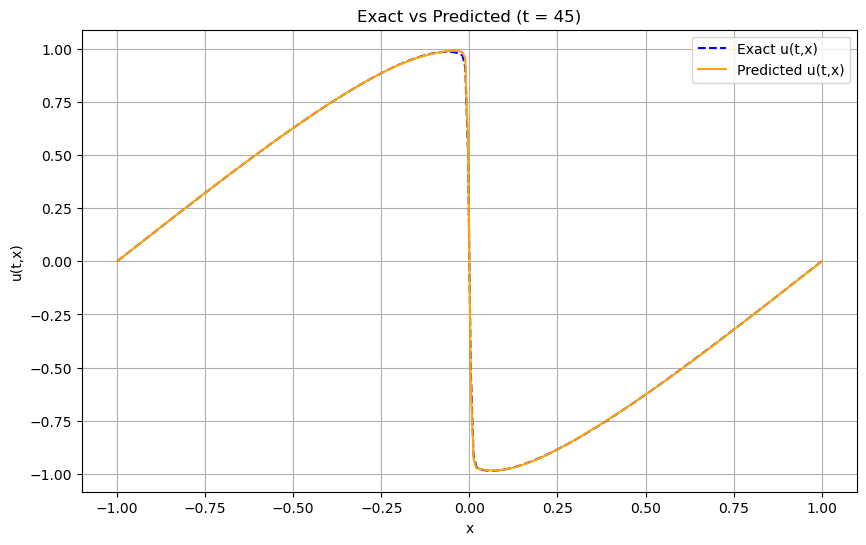

In [12]:
import matplotlib.pyplot as plt

def plot_exact_vs_pred_at_time(X, U_pred, Exact, t_idx, title="Exact vs Predicted at time t"):
    """
    Plot Exact and U_pred along x-axis at a specific time index (t_idx).
    
    Parameters:
    X      : 1D array-like, representing x-axis values
    U_pred : 2D array-like, predicted u(t,x) values
    Exact  : 2D array-like, exact u(t,x) values
    t_idx  : int, index for the specific time to plot
    title  : str, title for the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Plot Exact and U_pred for the specified time index
    plt.plot(X[0], Exact[t_idx], label='Exact u(t,x)', color='blue', linestyle='--')
    plt.plot(X[0], U_pred[t_idx], label='Predicted u(t,x)', color='orange', linestyle='-')
    
    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.title(f"{title} (t = {t_idx})")
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.show()

# Example usage
plot_exact_vs_pred_at_time(X, U_pred, Exact, t_idx=45, title="Exact vs Predicted")
